In [24]:
import os

curr_folder = os.getcwd() + "/"
datasets_folder = curr_folder[:-6] + "Datasets/"
stats_results_folder = curr_folder + "Results/"
print(datasets_folder)
print(stats_results_folder)

/home/ipsilva/Repositories/dynamic-projections/Datasets/
/home/ipsilva/Repositories/dynamic-projections/Stats/Results/


In [25]:
datasets_subfolders = []
for i in os.walk(datasets_folder):
    datasets_subfolders.append(i[0])

datasets_subfolders = datasets_subfolders[1:]
datasets_subfolders

['/home/ipsilva/Repositories/dynamic-projections/Datasets/gaussians',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/quickdraw',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/sorts',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/walk',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/nnset',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/fashion',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/cifar10cnn',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/esc50',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/qtables',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/cartolastd']

In [26]:
dataset_number = 5
selected_dataset = datasets_subfolders[dataset_number]
selected_dataset

'/home/ipsilva/Repositories/dynamic-projections/Datasets/fashion'

In [27]:
from os import listdir
from os.path import isfile, join

files = [f for f in listdir(selected_dataset) if isfile(join(selected_dataset, f))]
files[:5]

['tshirt-787-0.png',
 'bag-258-1.png',
 'trouser-450-8.png',
 'trouser-426-3.png',
 'sandal-416-2.png']

In [28]:
from sklearn.preprocessing import normalize
from itertools import product
import pandas as pd
import numpy as np
import cv2
import re

images_as_lines = []

obs_per_timestep = {}
for file in files:
    file_loc = selected_dataset + "/" + file
    image = cv2.imread(file_loc)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    line = normalize(gray, axis=0, norm='max').reshape(-1)
    images_as_lines.append(line)
    
    time = re.search("[0-9]+.png$", file).group()
    try:
        obs_per_timestep[time] == False
        obs_per_timestep[time] += 1
    except:
        obs_per_timestep[time] = 1

obs_per_timestep = list(obs_per_timestep.values())
median_obs_per_timestep = np.median(obs_per_timestep)
dev_obs_per_timestep = np.std(obs_per_timestep)

(i,j) = gray.shape
i_l = [i_e for i_e in range(i)]
j_l = [j_e for j_e in range(j)]
columns = list(product(i_l, j_l))        
df = pd.DataFrame(images_as_lines, columns=columns)
print(df.shape, df.head())

(10000, 784)      (0, 0)    (0, 1)    (0, 2)   (0, 3)    (0, 4)    (0, 5)    (0, 6)  \
0  0.008197  0.000000  0.200000  0.00000  0.280851  0.000000  0.000000   
1  0.058824  0.000000  0.000000  0.00000  0.160784  0.250980  0.501961   
2  0.739130  0.827586  0.333333  0.00000  0.000000  0.250000  0.448276   
3  0.000000  0.474820  0.033557  0.00000  0.117347  0.052632  0.410480   
4  0.033113  0.047059  0.247863  0.11828  0.241379  0.086275  0.000000   

     (0, 7)  (0, 8)    (0, 9)  ...  (27, 18)  (27, 19)  (27, 20)  (27, 21)  \
0  0.428571     0.0  0.313725  ...  0.066667  0.000000       0.0  0.788235   
1  0.000000     0.0  0.200000  ...  0.000000  0.000000       0.0  0.000000   
2  0.000000     0.0  0.000000  ...  0.000000  0.000000       0.0  0.000000   
3  0.314286     0.0  1.000000  ...  0.164706  0.000000       0.0  0.187879   
4  0.403922     0.0  0.270588  ...  0.874510  0.019608       0.0  0.176471   

   (27, 22)  (27, 23)  (27, 24)  (27, 25)  (27, 26)  (27, 27)  
0  0.4549

In [29]:
from sklearn.decomposition import PCA

def intrisic_dim(dataframe, target_variance):
    pca = PCA()

    principalComponents = pca.fit_transform(df)

    list_variance = pca.explained_variance_ratio_

    final_var = 0
    dims = 0
    for var in list_variance:
        final_var += var
        dims += 1
        if final_var > target_variance:
            break
    return dims, final_var, principalComponents[:dims]

In [30]:
target_variance = 0.9

(dims, final_var, components) = intrisic_dim(df, target_variance)

print("Total time-steps:", len(obs_per_timestep))
print("Registers per time-step (median):", median_obs_per_timestep)
print("Registers per time-step (deviation):", dev_obs_per_timestep)
print("Total dimensions:", df.shape[1])
print("Intrinsic dimensions:", dims)
print("Total variance:", final_var)

Total time-steps: 10
Registers per time-step (median): 1000.0
Registers per time-step (deviation): 0.0
Total dimensions: 784
Intrinsic dimensions: 541
Total variance: 0.9000049253393786


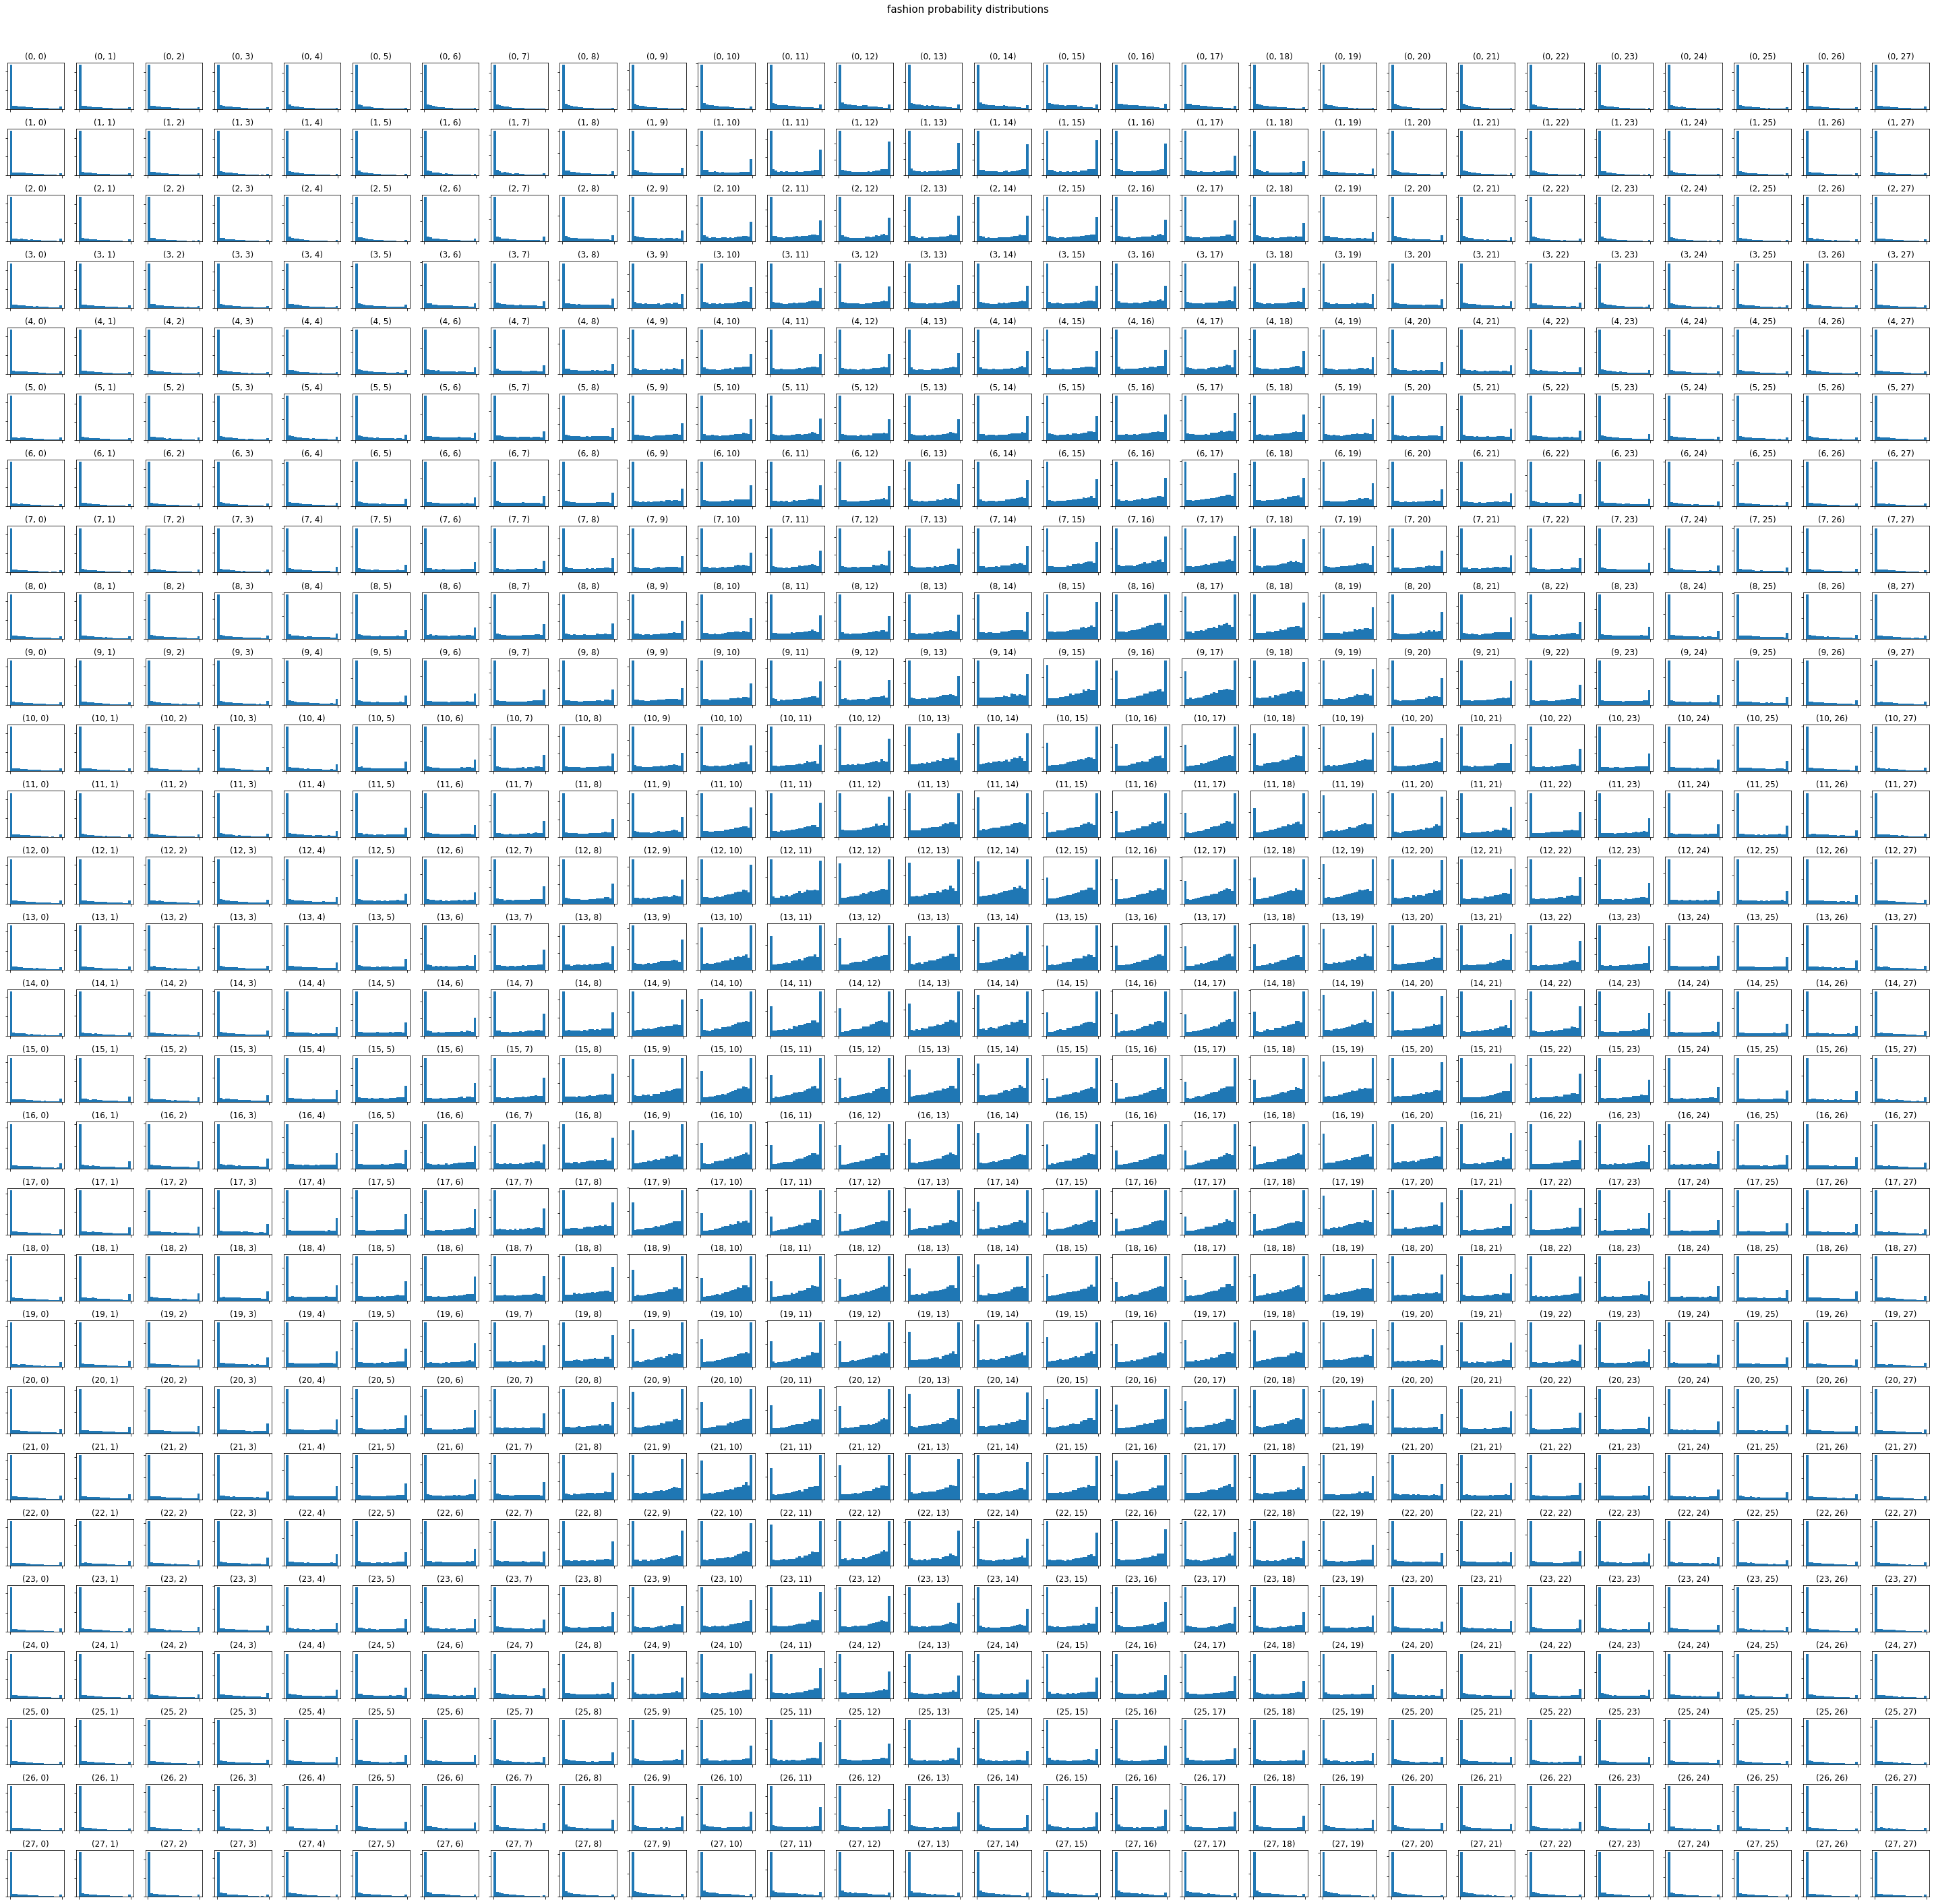

In [31]:
import matplotlib.pyplot as plt

# identifying distributions
hists_ax = df.hist(bins=20, grid=False, figsize=(40,40), density=True)

for arr in hists_ax:
    for ax in arr:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
fig_name = selected_dataset.split('/')[-1]
plt.suptitle(fig_name + " probability distributions", fontsize=15, weight='roman')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(stats_results_folder+"attribute_histograms/"+fig_name+"_prob_dist")